In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [341]:

bank=pd.read_csv('data.csv')
bank.head()



,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [342]:
bank.describe()

,Id,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45202.000000,45208.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,23606.000000,40.954714,1362.346620,15.806419,258.163080,2.763841,40.197828,0.580323
std,13051.435847,11.539144,3044.852387,8.322476,257.527812,3.098021,100.128746,2.303441
min,1001.000000,-1.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,12303.500000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,23606.000000,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,34908.500000,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,46211.000000,999.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [343]:
bank.isnull().sum(axis=0)

Id           0
age          9
job          0
marital      0
education    0
default      0
balance      3
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [344]:
bank.dropna(inplace=True)

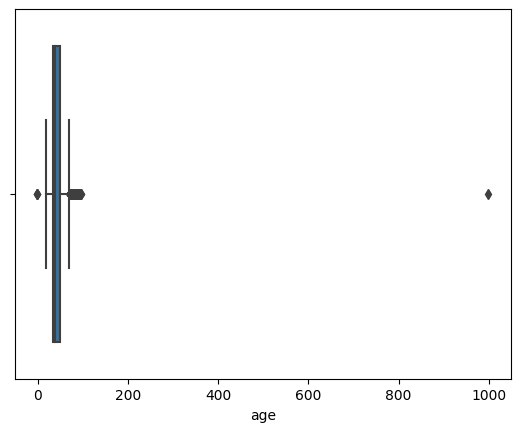

In [345]:
g = sns.boxplot(x=bank["age"])
Q1, Q2, Q3 = bank.age.quantile([0.25, 0.5, 0.75])
IQR = Q3 - Q1
bank.drop(bank[bank['age'].apply(lambda p: (p > Q3 + 1.5 * IQR) or (p < Q1 - 1.5 * IQR))].index, inplace = True)


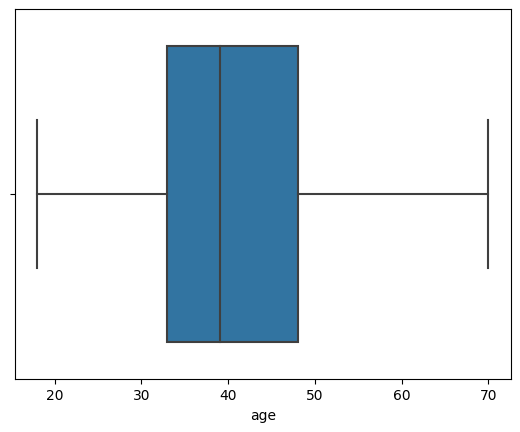

In [346]:
g = sns.boxplot(x=bank["age"])

In [419]:
bank_data = bank.copy()

In [389]:
bank_data['poutcome'] = bank_data['poutcome'].replace(['other'] , 'unknown')

In [390]:
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)
bank_data.drop('Id', axis=1, inplace = True)
bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 10000

In [391]:
bank_data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
45201,53.0,management,married,tertiary,no,583.0,no,no,cellular,226,1,184,4,success,yes
45202,34.0,admin.,single,secondary,no,557.0,no,no,cellular,224,1,10000,0,unknown,yes
45206,51.0,technician,married,tertiary,no,825.0,no,no,cellular,977,3,10000,0,unknown,yes
45209,57.0,blue-collar,married,secondary,no,668.0,no,no,telephone,508,4,10000,0,unknown,no
45210,37.0,entrepreneur,married,secondary,no,2971.0,no,no,cellular,361,2,188,11,unknown,no


In [396]:
test_data = bank_data.sample(frac=0.2)
sampled_indices = test_data.index
train_data = bank_data.drop(index=sampled_indices)
print(len(train_data))
print(len(test_data))

35768
8942


In [414]:
class Leaf_Node:
    def __init__(self, label):
        self.label = label
        self.children = dict()
class Decision_Node:
    def __init__(self, attribute, split_point, continous_att):
        self.attribute = attribute
        self.contninous_att = continous_att
        self.split_point = split_point
        self.children = dict()
        
class DecisionTree:
    def __init__(self, ASM = 'info_gain', max_depth = None, min_samples_split = 2, min_impurity_reduction = 0.0):
        self.root = None
        self.ASM = ASM
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_reduction = min_impurity_reduction
    
    def entropy(self, series): #the series should only contain the target feature values
        value_counts = dict(series.value_counts()) 
        ent = 0
        for j in value_counts:
            if value_counts[j]>0:
                term = -1 * (value_counts[j]/len(series))*np.log2(value_counts[j]/len(series))
            else:
                term = 0
            ent += term
        return ent

    def info_gain(self, examples, attribute, target_feature):
        value_counts = dict(examples[attribute].value_counts())
        remainder = np.sum( [value_counts[j]/len(examples[attribute]) * self.entropy(examples[examples[attribute] == j][target_feature]) for j in value_counts])
        return self.entropy(examples[target_feature]) - remainder

    def continuous_to_boolean(self, row, att, midpoint):
        if(row[att] > midpoint):
            row[att] = f"{att}>{midpoint}"    
        else:
            row[att] = f"{att}<{midpoint}"
        return row

    def INFO_GAIN_ASM(self, examples, attributes, target_feature):
        max_gain, best_att, split_point = 0, '', None
        for att in attributes:
            if attributes[att]:#if the feature is continous 
                for quartile in list(examples[att].quantile([0.25, 0.5, 0.75])): #try its deciles/quartiles 
                    examples_cont_splitted = examples.apply(lambda x :self.continuous_to_boolean(x, att, quartile), axis = 1)
                    info = self.info_gain(examples_cont_splitted, att, target_feature)
                    if info > max_gain:
                        max_gain = info
                        best_att = att
                        split_point = quartile
            else:
                info = self.info_gain(examples, att, target_feature)
                if (info >= max_gain):
                    max_gain = info
                    best_att = att
        return best_att, split_point



    def gini_coef(self, series):
        value_counts = dict(series.value_counts()) 
        gini_coef = 1
        for target in value_counts:
            if(value_counts[target] > 0):
                gini_coef -= (value_counts[target]/(len(series)))**2

        return gini_coef

    def impurity_reduction(self, examples, attribute, target_feature):
        value_counts = dict(examples[attribute].value_counts())
        gini = np.sum( [value_counts[j]/len(examples[attribute]) * self.gini_coef(examples[examples[attribute] == j][target_feature]) for j in value_counts])

        return self.gini_coef(examples[target_feature]) - gini

    def GINI_ASM(self, examples, attributes, target_feature):
        max_impurity_reduction, best_att, split_point = 0, '', None
        for att in attributes:
            if attributes[att]:#if the feature is continous 
                for quartile in list(examples[att].quantile([0.25,0.5,0.75])): #try its quartiles 
                    examples_cont_splitted = examples.apply(lambda x : self.continuous_to_boolean(x, att, quartile), axis = 1)
                    impurity_reduction_for_att = self.impurity_reduction(examples_cont_splitted, att, target_feature)

                    if impurity_reduction_for_att > max_impurity_reduction:
                        max_impurity_reduction = impurity_reduction_for_att
                        best_att = att
                        split_point = quartile
        
            else:
                impurity_reduction_for_att = self.impurity_reduction(examples, att, target_feature)
                if impurity_reduction_for_att >= max_impurity_reduction:
                    max_impurity_reduction = impurity_reduction_for_att
                    best_att = att
        return best_att, split_point

    
    def _GenerateTree(self, examples: pd.DataFrame, attributes: dict[str : bool], target_feature: str, ASM , max_depth, min_samples_split, min_impurity_reduction, current_depth):
        if max_depth is None:
            max_depth = len(examples)
        # check for base cases and current depth 
        if (len(examples[target_feature].value_counts()) == 1) or (len(attributes) == 0) or (current_depth > max_depth):
            return Leaf_Node(examples[target_feature].mode().iloc[0])
        
        else:
            current_depth += 1
            
            if (ASM == "info_gain"):
                splitting_att, split_point = self.INFO_GAIN_ASM(examples, attributes, target_feature) 
            elif (ASM == "gini_index"):
                splitting_att, split_point = self.GINI_ASM(examples, attributes, target_feature) 
            else:
                raise ValueError("Unknown attribute selection measure")
            #pre-prune
            if splitting_att == '' or self.impurity_reduction(examples, splitting_att, target_feature) < min_impurity_reduction: #if the splitting_att is '' the info_gain/gini has been zero
                return Leaf_Node(examples[target_feature].mode().iloc[0])
            
             
            if(attributes[splitting_att]): #if the splitting feature is continous 
                root = Decision_Node(splitting_att, split_point, True)  #label node N with splitting criterion as a continous variable;
                rb_l = None

                if len(new_examples := examples[examples[splitting_att] > split_point]) < min_samples_split:
                    root.children[f"bigger than {split_point}"] = Leaf_Node(new_examples[target_feature].mode().iloc[0]) 
                    rb_l = root.children[f"bigger than {split_point}"].label
                else:
                    root.children[f"bigger than {split_point}"] = self._GenerateTree(new_examples, {att:attributes[att] for att in attributes if att != splitting_att}, target_feature, ASM, max_depth = max_depth, min_samples_split = min_samples_split, min_impurity_reduction = min_impurity_reduction, current_depth = current_depth)

                if len(new_examples := examples[examples[splitting_att] <= split_point]) < min_samples_split:
                    root.children[f"smaller than {split_point}"] = Leaf_Node(new_examples[target_feature].mode().iloc[0])
                    if(root.children[f"smaller than {split_point}"].label == rb_l):
                        root = Leaf_Node(examples[target_feature].mode().iloc[0])
                else:
                    root.children[f"smaller than {split_point}"] = self._GenerateTree(new_examples,  {att:attributes[att] for att in attributes if att != splitting_att}, target_feature, ASM, max_depth = max_depth, min_samples_split = min_samples_split, min_impurity_reduction = min_impurity_reduction, current_depth = current_depth)

            else:
                root = Decision_Node(splitting_att, split_point, False)

                for item in  examples[splitting_att].unique(): #new node
                    if len(new_examples := examples[examples[splitting_att] == item]) < min_samples_split:
                        root.children[item] = Leaf_Node(examples[target_feature].mode().iloc[0]) 
                    else:
                        root.children[item] = self._GenerateTree(new_examples,  {att:attributes[att] for att in attributes if att != splitting_att}, target_feature, ASM, max_depth = max_depth, min_samples_split = min_samples_split, min_impurity_reduction = min_impurity_reduction, current_depth = current_depth)
        return root
    
    def fit(self, examples: pd.DataFrame, attributes: dict[str : bool], target_feature: str):
        self.root = self._GenerateTree(examples, attributes, target_feature, ASM = self.ASM, max_depth = self.max_depth, min_samples_split = self.min_samples_split, min_impurity_reduction = self.min_impurity_reduction, current_depth = 0)
    
    
    
    def display_tree(self):
        self._display_node(self.root, 0)

    def _display_node(self, node, depth):
        if isinstance(node, Leaf_Node):
            print("  " * depth, "o Leaf Node:", node.label)
        elif isinstance(node, Decision_Node):
            print("  " * depth, "- Decision Node:", node.attribute)
            for value, child_node in node.children.items():
                print("  " * (depth + 1), f"Value: {value}")
                self._display_node(child_node, depth + 1)


    def predict(self, examples):
        return pd.Series([self._predict_recursive(example, self.root) for _, example in examples.iterrows()], index=examples.index)
    def _predict_recursive(self, example, node):
        if isinstance(node, Leaf_Node):
            return node.label
        elif isinstance(node, Decision_Node):
            attribute_value = example[node.attribute]
            if node.contninous_att:
                if attribute_value <= node.split_point:
                    next_node = node.children[f"smaller than {node.split_point}"]
                else:
                    next_node = node.children[f"bigger than {node.split_point}"]
                return self._predict_recursive(example, next_node)
            else:
                if attribute_value in node.children:
                    next_node = node.children[attribute_value]
                    return self._predict_recursive(example, next_node)
                else:
                    return None
        else:
            raise ValueError


    def accuracy(self, predicted_labels, true_labels): # TP + TN / all examples
        predicted_labels = predicted_labels.loc[true_labels.index]

        # Count the number of correctly predicted labels
        correct_predictions = (predicted_labels == true_labels).sum()

        # Calculate the accuracy as a percentage
        accuracy = (correct_predictions / len(true_labels)) * 100

        return accuracy
    
    def precision(self, predicted_labels, true_labels, class_of_interest): #TP / TP + FP
        predicted_labels = predicted_labels.loc[true_labels.index]

        # tp
        true_positives = ((predicted_labels == class_of_interest) & (predicted_labels == true_labels)).sum()

        # tp + fp
        predicted_positives = (predicted_labels == class_of_interest).sum()

        if predicted_positives == 0:
            precision = 0
        else:
            precision = (true_positives / predicted_positives) * 100
        return precision
    
    def recall(self, predicted_labels, true_labels, class_of_interest): #TP / TP + FN
        predicted_labels = predicted_labels.loc[true_labels.index]
        true_positives = ((predicted_labels == class_of_interest) & (predicted_labels == true_labels)).sum()
        false_negatives = ((predicted_labels != class_of_interest) & (predicted_labels != true_labels)).sum()
        if true_positives == 0:
            recall = 0
        else:
            recall = ((true_positives)/(true_positives + false_negatives))*100
        return recall
    
    def F1_score(self, predicted_labels, true_labels, class_of_interest):
        F1_score = 1/((1/self.recall(predicted_labels, true_labels, class_of_interest)) + (1/self.precision(predicted_labels, true_labels, class_of_interest)))
        return F1_score
    
    def Macro_F1(self, predicted_labels, true_labels):
        return np.average([self.F1_score(predicted_labels, true_labels, target) for target in predicted_labels])
        
    def cross_val_score(self, all_examples, attributes, target_feature, k=5):
        scores = []
        n = len(all_examples)
        indices = np.arange(n)
        np.random.shuffle(indices)
        fold_size = n // k
        for i in range(k):

            start = i * fold_size
            end = (i + 1) * fold_size if i < k - 1 else n
            test_indices = indices[start:end]
            train_indices = np.concatenate((indices[:start], indices[end:]))
            examples_train = all_examples.iloc[train_indices]
            examples_test = all_examples.iloc[test_indices]
            examples_test_without_y = examples_test.drop(target_feature, axis = 1)
            print(f"fold {i}. \n")
            self.fit(examples_train, attributes, target_feature)
            y_pred = self.predict(examples_test_without_y)
            score = self.accuracy(y_pred, examples_test[target_feature])
            scores.append(score)
        return scores



In [394]:
attributes = {i:j for i,j in zip(bank_data.columns.drop('y'), [True, False, False, False, False, True, False, False, False, True, True, True, True, False])}
attributes

{'age': True,
 'job': False,
 'marital': False,
 'education': False,
 'default': False,
 'balance': True,
 'housing': False,
 'loan': False,
 'contact': False,
 'duration': True,
 'campaign': True,
 'pdays': True,
 'previous': True,
 'poutcome': False}

In [409]:

dt_info = DecisionTree(ASM = 'info_gain', max_depth = 4, min_samples_split = 100)
dt_info.fit(train_data, attributes, 'y' )

In [410]:
dt_gini = DecisionTree(ASM = 'gini_index', max_depth = 4, min_samples_split = 100)
dt_gini.fit(train_data, attributes, 'y' )

In [412]:

predictions_with_info = dt_info.predict(test_data.drop('y', axis = 1))
dt_info.accuracy(predictions_with_info, test_data['y'])


89.68910758219639

In [413]:
predictions_with_gini = dt_gini.predict(test_data.drop('y', axis = 1))
dt_gini.accuracy(predictions_with_gini, test_data['y'])

89.68910758219639

In [405]:
dt_info.Macro_F1(predictions_with_info, test_data['y'])

46.03699628109842

In [417]:
dt_info.cross_val_score(bank_data, attributes, "y")

fold 0: 

fold 1: 

fold 2: 

fold 3: 

fold 4: 



[89.26414672332812,
 90.00223663609931,
 89.08521583538358,
 89.71147394318945,
 89.82330574815478]

In [418]:
dt_info.display_tree()

 - Decision Node: duration
   Value: bigger than 319.0
   - Decision Node: poutcome
     Value: unknown
     - Decision Node: contact
       Value: cellular
       - Decision Node: job
         Value: technician
         - Decision Node: marital
           Value: married
           o Leaf Node: no
           Value: single
           o Leaf Node: no
           Value: divorced
           o Leaf Node: no
         Value: admin.
         - Decision Node: housing
           Value: no
           o Leaf Node: no
           Value: yes
           o Leaf Node: no
         Value: unemployed
         - Decision Node: marital
           Value: single
           o Leaf Node: no
           Value: married
           o Leaf Node: no
           Value: divorced
           o Leaf Node: no
         Value: management
         - Decision Node: balance
           Value: bigger than 676.0
           o Leaf Node: no
           Value: smaller than 676.0
           o Leaf Node: no
         Value: blue-collar
     